# Quantum Optimal Control for Spin-J Systems

**Author:** pmpoggi @ strath (March 2025)

This notebook implements state control for collective spin-J systems, focusing on the preparation of Dicke states through optimal control of two-axis driving fields.

## Import Required Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as alg2
import scipy.optimize as optim

# Set matplotlib font size
plt.rcParams['font.size'] = 14

## Collective Spin System Definitions

Define functions for generating Clebsch-Gordon coefficients and collective spin operators.

In [3]:
def cg(s, j, m):
    """Clebsch Gordon coefficients, s = +1 or -1"""
    return np.sqrt(j*(j+1) - m*(m+s))

def gen_j_mat(n):
    """Generate collective spin matrices for N particles"""
    J = n/2.
    d = int(2*J + 1)
    
    # Jz operator (diagonal)
    Jz_vec = np.arange(J, -(J+1), -1)
    Jz = 1j*np.diag(Jz_vec)/(1j)
    
    # J+ and J- operators
    JM_vec = np.zeros(d, dtype=complex)
    Jm_vec = np.zeros(d, dtype=complex)
    
    for i in range(d):
        m = -J + i
        JM_vec[i] = cg(1, J, m)
        Jm_vec[i] = cg(-1, J, m)
    
    JM = np.diag(JM_vec[0:d-1], 1)  # Upper diagonal
    Jm = np.diag(Jm_vec[1:], -1)    # Lower diagonal
    
    # Jx and Jy operators
    Jx = 0.5*(JM + Jm)
    Jy = -1j*0.5*(JM - Jm)
    
    # Identity operator
    Id = np.identity(d)
    
    return [Id, Jx, Jy, Jz]

## System Parameters and Setup

Define the collective spin system parameters and generate the spin operators.

In [4]:
# System parameters
N = 4  # number of particles
J = N/2  # total angular momentum
dim = N + 1  # dimension of Hilbert space

# Generate collective spin operators
[Id, Jx, Jy, Jz] = gen_j_mat(int(2*J))
Ji = [Jx, Jy, Jz]
Jz2 = np.dot(Jz, Jz)  # Jz squared
Jx2 = np.dot(Jx, Jx)  # Jx squared

print(f"System: N = {N} particles")
print(f"Total angular momentum: J = {J}")
print(f"Hilbert space dimension: {dim}")
print(f"Jz eigenvalues: {np.arange(J, -(J+1), -1)}")

System: N = 4 particles
Total angular momentum: J = 2.0
Hilbert space dimension: 5
Jz eigenvalues: [ 2.  1.  0. -1. -2.]


## Optimization and Evolution Parameters

Set up the control parameters and define initial and target states.

In [5]:
# Control parameters
omega = 3  # driving strength
beta_max = 1  # interaction strength

# Time evolution parameters
Tf = 2*np.pi/beta_max  # Total evolution time
pasos = np.linspace(0.01, 1.5, 15)  # vector for total evolution times
# pasos = [5]  # uncomment for single time evolution
Nts = 15  # Number of time steps for the field
Num_tries = 1  # Number of optimization attempts

# Target and initial states
k_exc = 1  # number of excitations in the target state: Dicke (M = J-k)
psi_target = np.identity(dim)[k_exc]  # Dicke state |J, J-k⟩
targ_lab = f'dicke{k_exc}'
psi0 = np.identity(dim)[0]  # SCS (Spin Coherent State) all up |J, J⟩

# Optimization parameters
metodo = 'L-BFGS-B'  # BFGS or L-BFGS-B
grad_tol = 1e-04  # tolerance for gradient

print(f"Initial state: |J, J⟩ = |{J}, {J}⟩ (all spins up)")
print(f"Target state: |J, J-{k_exc}⟩ = |{J}, {J-k_exc}⟩ (Dicke state with {k_exc} excitation(s))")
print(f"Control fields: Two-axis driving (Jx and Jy)")
print(f"Interaction: Jz² with strength β = {beta_max}")

Initial state: |J, J⟩ = |2.0, 2.0⟩ (all spins up)
Target state: |J, J-1⟩ = |2.0, 1.0⟩ (Dicke state with 1 excitation(s))
Control fields: Two-axis driving (Jx and Jy)
Interaction: Jz² with strength β = 1


## Hamiltonian Definition

Define the time-dependent Hamiltonian with two control fields and quadratic interaction.

In [6]:
def Hami(x1, x2):
    """
    Time-dependent Hamiltonian:
    H = ω[cos(x1)Jx + cos(x2)Jy] + β_max*Jz²
    
    Parameters:
    x1, x2: Control field parameters
    """
    h1 = omega*(np.cos(x1)*Jx + np.cos(x2)*Jy)  # Two-axis driving
    h2 = beta_max*Jz2  # Quadratic interaction
    return h1 + h2

## Optimization Cost Function

Define the cost function for state transfer optimization (using numerical gradients).

In [7]:
def optim_cost(x):
    """
    Cost function: 1 - |⟨ψ_target|ψ_final⟩|²
    
    Parameters:
    x: Control field array [x1_0, ..., x1_Nts, x2_0, ..., x2_Nts]
    """
    # Split control fields
    X1 = x[0:Nts]      # First control field (Jx component)
    X2 = x[Nts:2*Nts]  # Second control field (Jy component)
    
    # Initialize state evolution
    psit = np.zeros([Nts+1, dim], dtype=complex)
    psit[0] = psi0
    
    # Time evolution arrays (not used in this cost function but kept for completeness)
    Ut = np.zeros([Nts+1, dim, dim], dtype=complex)
    Ut[0] = np.identity(dim)
    
    # Evolve state through time steps
    for kt in range(Nts):
        h = Hami(X1[kt], X2[kt])
        Udt = alg2.expm(-1j*h*dt)  # Time evolution operator
        psit[kt+1] = np.dot(Udt, psit[kt])  # Evolve state
    
    # Calculate fidelity with target state
    Jtarget = 1 - abs(np.vdot(psit[-1], psi_target))**2
    
    return Jtarget

## Main Optimization Loop

Run the optimization for different evolution times and multiple attempts.

In [8]:
# Initialize storage for results
cost_opt = np.zeros([Num_tries, len(pasos)])

# Main optimization loop
for kt in range(Num_tries):
    # Random initial guess for control fields
    guess_rand = 2*np.pi*(np.random.rand(2*Nts) - 0.5)
    field_opt = 0

    # Loop over different evolution times (reverse order for warm starting)
    for kp in range(len(pasos))[::-1]:
        T = pasos[kp]*Tf  # Current evolution time
        t = np.linspace(0, T, Nts+1)
        dt = t[1] - t[0]  # Time step
        
        # Set initial guess (random for first, previous result for others)
        if kp == len(pasos)-1:
            phi0 = guess_rand
        else:
            phi0 = field_opt
        
        print("call scipy.optimize.minimize...")
        
        # Run optimization
        # Option 1: With bounds
        # opt_result = optim.minimize(optim_cost, x0=phi0, method=metodo, 
        #                           bounds=optim.Bounds(-np.pi, np.pi), 
        #                           options={'gtol': grad_tol, 'disp': True})
        
        # Option 2: Without bounds (current choice)
        opt_result = optim.minimize(optim_cost, x0=phi0, method=metodo, 
                                  options={'gtol': grad_tol, 'disp': False})
        
        # Store results
        field_opt = opt_result['x']
        final_cost = opt_result['fun']
        cost_opt[kt, kp] = final_cost
        
        print("[Try %d of %d] Step %d of %d. Optimized cost: %.12f" % 
              (kt+1, Num_tries, kp+1, len(pasos), final_cost))

print("\nOptimization completed!")

call scipy.optimize.minimize...
[Try 1 of 1] Step 15 of 15. Optimized cost: 0.000000000008
call scipy.optimize.minimize...
[Try 1 of 1] Step 14 of 15. Optimized cost: 0.000000000748
call scipy.optimize.minimize...
[Try 1 of 1] Step 13 of 15. Optimized cost: 0.000000001914
call scipy.optimize.minimize...
[Try 1 of 1] Step 12 of 15. Optimized cost: 0.000000022802
call scipy.optimize.minimize...
[Try 1 of 1] Step 11 of 15. Optimized cost: 0.000000001456
call scipy.optimize.minimize...
[Try 1 of 1] Step 10 of 15. Optimized cost: 0.000000000151
call scipy.optimize.minimize...
[Try 1 of 1] Step 9 of 15. Optimized cost: 0.000000000460
call scipy.optimize.minimize...
[Try 1 of 1] Step 8 of 15. Optimized cost: 0.000000013680
call scipy.optimize.minimize...
[Try 1 of 1] Step 7 of 15. Optimized cost: 0.000000000513
call scipy.optimize.minimize...
[Try 1 of 1] Step 6 of 15. Optimized cost: 0.000000010890
call scipy.optimize.minimize...
[Try 1 of 1] Step 5 of 15. Optimized cost: 0.003614847400
call

## Results Analysis and Visualization

Analyze the optimization results and plot the cost function vs evolution time.

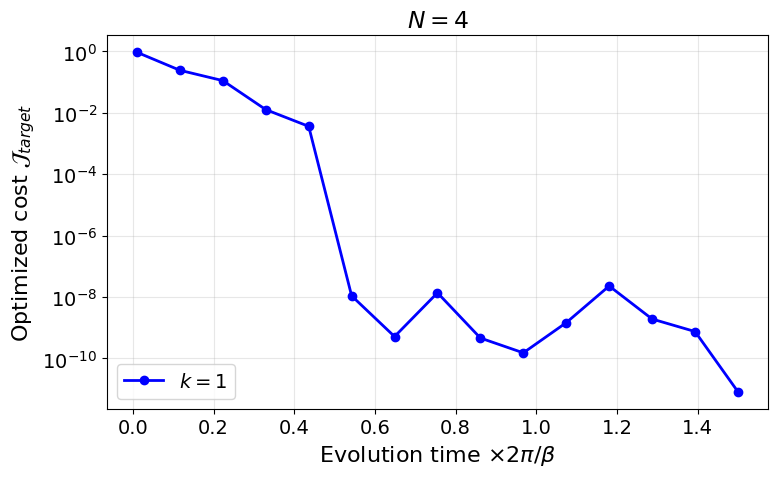

In [9]:
# Data saving (commented out - uncomment if needed)
# np.savetxt(f"data_qoc/J{int(J)}_cost_kexc_{k_exc}_Nts{Nts}.txt", cost_opt)
# np.savetxt(f"data_qoc/J{int(J)}_pasos.txt", pasos)

# Plotting parameters
color_k = ['b', 'r', 'g', 'm']

# Create figure
plt.figure(1, figsize=(8, 5))
plt.title(f"$N={N}$")

# Calculate minimum cost for each evolution time
cost_min = np.empty(len(pasos))
for kp in range(len(pasos)):
    cost_min[kp] = np.amin(cost_opt[:, kp])

# Plot minimum cost (main result)
plt.semilogy(pasos, cost_min, 'o-', color=color_k[k_exc-1], 
            label=f"$k={k_exc}$", linewidth=2, markersize=6)

# Plot individual attempts (with transparency)
for kt in range(Num_tries):
    plt.semilogy(pasos, cost_opt[kt, :], '-', color=color_k[k_exc-1], 
                alpha=0.2, linewidth=1)

plt.xlabel(r"Evolution time $\times 2\pi/\beta$", size=16)
plt.ylabel(r"Optimized cost $\mathcal{J}_{target}$", size=16)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

## Final State Analysis

Analyze the final optimized control fields and the achieved state transfer.

In [10]:
# Analyze the best result (shortest evolution time with good fidelity)
best_idx = np.argmin(cost_min)
best_cost = cost_min[best_idx]
best_time = pasos[best_idx]
best_fidelity = 1 - best_cost

print("=== OPTIMIZATION RESULTS ===")
print(f"System: N = {N} particles, J = {J}")
print(f"Target: |J, J-{k_exc}⟩ = |{J}, {J-k_exc}⟩ (Dicke state)")
print(f"Initial: |J, J⟩ = |{J}, {J}⟩ (all spins up)")
print(f"\nBest result:")
print(f"Evolution time: {best_time:.3f} × 2π/β = {best_time*Tf:.3f}")
print(f"Final cost: {best_cost:.2e}")
print(f"State transfer fidelity: {best_fidelity:.6f}")
print(f"Number of time steps: {Nts}")
print(f"Number of optimization attempts: {Num_tries}")

# Show the range of evolution times explored
print(f"\nEvolution time range: [{pasos[0]:.3f}, {pasos[-1]:.3f}] × 2π/β")
print(f"Total optimization points: {len(pasos)}")

=== OPTIMIZATION RESULTS ===
System: N = 4 particles, J = 2.0
Target: |J, J-1⟩ = |2.0, 1.0⟩ (Dicke state)
Initial: |J, J⟩ = |2.0, 2.0⟩ (all spins up)

Best result:
Evolution time: 1.500 × 2π/β = 9.425
Final cost: 8.18e-12
State transfer fidelity: 1.000000
Number of time steps: 15
Number of optimization attempts: 1

Evolution time range: [0.010, 1.500] × 2π/β
Total optimization points: 15
